## Ustawienie hardware

In [9]:
import torch
import random
import numpy as np
import gym
import warnings

# Ustawienia dla reprodukowalności
SEED = 42

OPTIMIZE_WITH_HARDWARE = True

device = torch.device('cpu')
if OPTIMIZE_WITH_HARDWARE:
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f'Wybrano urządzenie: MPS')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Wybrano urządzenie: GPU z obsługą CUDA')
        print(f'Nazwa urządzenia CUDA: {torch.cuda.get_device_name()}')
        print(f'Liczba urządzeń CUDA: {torch.cuda.device_count()}')
        print(f'Indeks urządzenia CUDA: {torch.cuda.current_device()}')
else:
    print(f'Wybrano urządzenie: CPU')

# Ustawienie ziaren losowych
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


warnings.filterwarnings("ignore")


Wybrano urządzenie: GPU z obsługą CUDA
Nazwa urządzenia CUDA: Quadro M1200
Liczba urządzeń CUDA: 1
Indeks urządzenia CUDA: 0


## Ogólne przedstawienie problemu

In [10]:
# Inicjalizacja środowiska
env = gym.make("LunarLander-v2")
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state = env.reset()
if isinstance(state, tuple):
    state = state[0]

terminated = False
truncated = False

while not (terminated or truncated):
    action = env.action_space.sample()  # Losowa akcja
    result = env.step(action)
    if len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        next_state, reward, done, info = result
    env.render()
    if done:
        break

env.close()


## Co zwraca środowisko?

Stan - wektor opisujący aktualne położenie i dynamikę lądownika.

- pozycja pozioma lądownika (x);
- pozycja pionowa lądownika (y)
- prędkość pozioma lądownika
- prędkość pionowa lądownika
- kąt nachylenia lądownika
- prędkość kątowa lądownika
- czy noga nr 1 (lewa) lądownika dotyka podłoża
- czy noga nr 2 (prawa) lądownika dotyka podłoża

## Ile akcji może wykonać agent?

In [11]:
print(f'Ilość możliwych akcji: {env.action_space.n}')

Ilość możliwych akcji: 4


1. Brak działania
2. Uruchomiony główny silnik
3. Uruchomiony lewy silnik
4. Uruchomiony prawy silnik

## Hiperparametry

In [12]:
# Hiperparametry
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
GAMMA = 0.99  # Współczynnik dyskontowania przyszłych nagród
EPSILON_START = 1.0  # Początkowa wartość współczynnika eksploracji
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995  # Współczynnik zmniejszania wartości epsilon (na epizod)
MEMORY_SIZE = 100000  # Maksymalny rozmiar pamięci przechowującej przejścia
TRAIN_START = 1000  # Rozpoczęcie uczenia po zebraniu danej liczby doświadczeń
TARGET_UPDATE_STEPS = 1000  # Aktualizacja sieci docelowej co określoną liczbę kroków
MAX_EPISODES = 500
MAX_STEPS = 1000  # Maksymalna liczba kroków w epizodzie

## Zaimportowanie niezbędnych bibliotek

In [13]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns


## Struktura sieci głębokiej

In [14]:
class DQNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Warstwa wejściowa
        self.fc2 = nn.Linear(256, 256)        # Warstwa ukryta
        self.fc3 = nn.Linear(256, output_size)  # Warstwa wyjściowa

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)  # Q-wartości dla każdej akcji
        return q_values


## Definicja agenta sieci DQN

In [15]:
class DQNAgent:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQNetwork(input_size, output_size).to(device)
        self.target_model = DQNetwork(input_size, output_size).to(device)
        self.update_target_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.loss_function = nn.SmoothL1Loss()
        self.total_steps = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.output_size)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
            return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < TRAIN_START:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.model(states).gather(1, actions)

        # Double DQN
        next_actions = self.model(next_states).argmax(1).unsqueeze(1)
        next_q_values = self.target_model(next_states).gather(1, next_actions).detach()

        target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

        loss = self.loss_function(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()

        # Obcinanie gradientów
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        self.optimizer.step()

        self.total_steps += 1
        if self.total_steps % TARGET_UPDATE_STEPS == 0:
            self.update_target_model()

    def decay_epsilon(self):
        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY
        else:
            self.epsilon = EPSILON_MIN
    

## Definicja pętli treningowej modelu

In [16]:
# Definicja pętli treningowej modelu
import warnings
warnings.filterwarnings('ignore')

env = gym.make("LunarLander-v2")
env.action_space.seed(SEED)
env.observation_space.seed(SEED)
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = DQNAgent(input_size, output_size)


episodes = MAX_EPISODES
rewards_history = []
total_steps = 0

for episode in range(episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    total_reward = 0
    done = False
    step = 0

    while not done and step < MAX_STEPS:
        action = agent.act(state)
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            next_state, reward, done, info = result

        agent.memorize(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state
        agent.replay()
        step += 1
        total_steps += 1

    agent.decay_epsilon()
    rewards_history.append(total_reward)

    print(f"Epizod {episode + 1}/{episodes}, Nagroda: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")


torch.save({
    'model_state_dict': agent.model.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
}, 'dqn_lunar_lander.pth')

env.close()


Epizod 1/500, Nagroda: -309.33, Epsilon: 0.995
Epizod 2/500, Nagroda: -133.19, Epsilon: 0.990
Epizod 3/500, Nagroda: -203.64, Epsilon: 0.985
Epizod 4/500, Nagroda: -78.42, Epsilon: 0.980
Epizod 5/500, Nagroda: -137.13, Epsilon: 0.975
Epizod 6/500, Nagroda: -117.25, Epsilon: 0.970
Epizod 7/500, Nagroda: -115.65, Epsilon: 0.966
Epizod 8/500, Nagroda: -385.91, Epsilon: 0.961
Epizod 9/500, Nagroda: -99.90, Epsilon: 0.956
Epizod 10/500, Nagroda: -256.48, Epsilon: 0.951
Epizod 11/500, Nagroda: -191.74, Epsilon: 0.946
Epizod 12/500, Nagroda: -83.60, Epsilon: 0.942
Epizod 13/500, Nagroda: -137.07, Epsilon: 0.937
Epizod 14/500, Nagroda: -399.91, Epsilon: 0.932
Epizod 15/500, Nagroda: -100.51, Epsilon: 0.928
Epizod 16/500, Nagroda: -229.16, Epsilon: 0.923
Epizod 17/500, Nagroda: -31.40, Epsilon: 0.918
Epizod 18/500, Nagroda: -108.41, Epsilon: 0.914
Epizod 19/500, Nagroda: -113.16, Epsilon: 0.909
Epizod 20/500, Nagroda: -103.91, Epsilon: 0.905
Epizod 21/500, Nagroda: -305.11, Epsilon: 0.900
Epizo

## Wykresy

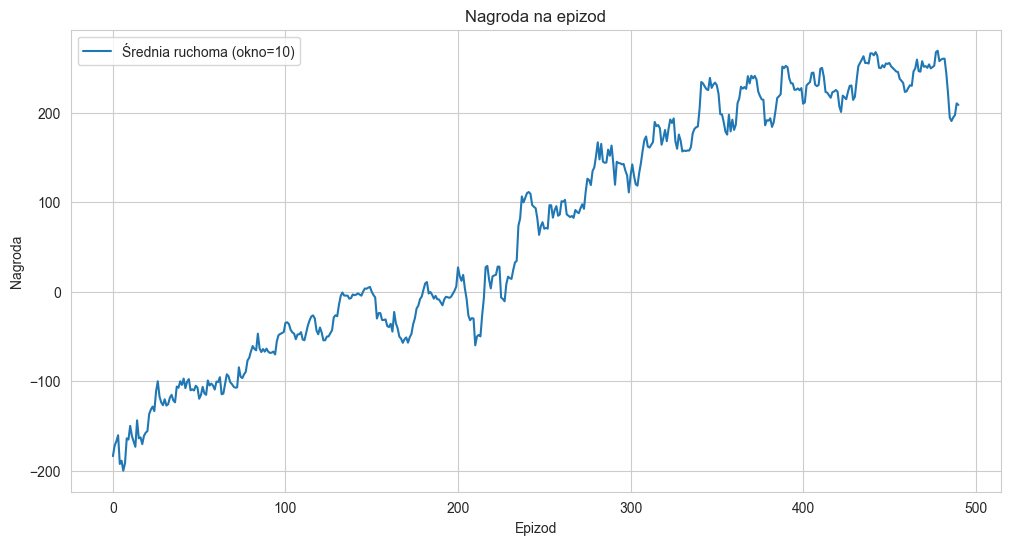

In [17]:
# Wykresy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

window_size = 10
moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
x = np.arange(len(moving_avg))

plt.figure(figsize=(12,6))
plt.plot(x, moving_avg, label=f"Średnia ruchoma (okno={window_size})")
plt.title("Nagroda na epizod")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.legend()
plt.show()


## Testowanie modelu

In [18]:
# Testowanie modelu

# Inicjalizacja urządzenia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Stwórz środowisko
env = gym.make('LunarLander-v2', render_mode='human')
env.action_space.seed(SEED)
env.observation_space.seed(SEED)
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

# Załaduj wytrenowany model
model = DQNetwork(input_size, output_size).to(device)
checkpoint = torch.load('dqn_lunar_lander.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Ustaw epsilon na zero (choć nie jest używany podczas testowania)
epsilon = 0.0

# Testuj model
for episode in range(5):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    total_reward = 0
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        action = torch.argmax(q_values).item()
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            next_state, reward, done, info = result
        state = next_state
        total_reward += reward
        env.render()
    print(f'Epizod {episode + 1}: Łączna nagroda: {total_reward:.2f}')
env.close()


Epizod 1: Łączna nagroda: 274.62
Epizod 2: Łączna nagroda: 252.21
Epizod 3: Łączna nagroda: 275.69
Epizod 4: Łączna nagroda: 277.82
Epizod 5: Łączna nagroda: 285.74
